In [66]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
# from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

$r_{ij} = r_i - r_j$
$$
U(r_{ij}) = 4\varepsilon [(\sigma/r_{ij})^{12} - (\sigma/r_{ij})^6] \\
U^*(r_{ij}) = 4[(r_{ij}^*)^{-12} - (r_{ij}^*)^{-6}] \\
\phantom{U^*(r_{ij})} = 4[(r_{ij}^*)^{-6} - 1](r_{ij}^*)^{-6} \\
$$
Force atom $j$ exerts on $i$
$$
\vec{F}^*(r_{ij}) = 48[(r_{ij}^*)^{-6} - 0.5](r_{ij}^*)^{-8} \vec{r_{ij}^*} \\
$$

[19.74111019 15.9565494 ]
(2, 210)
210


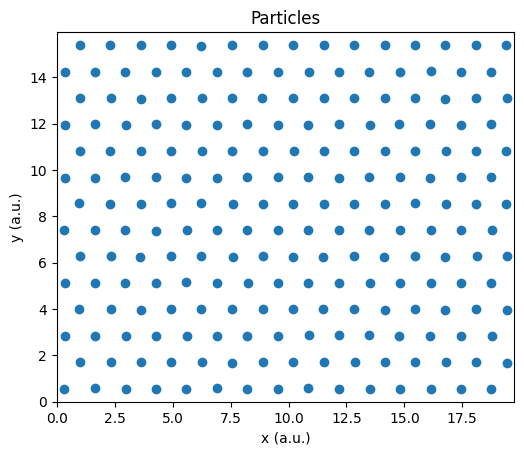

In [67]:
# SET UP RANDOM INITIAL CONDITIONS
rng = np.random.default_rng(seed=102)

X_U_MIN = 2**(1/6)*1
N_L = 15
# N = N_L*N_L
DIM = 2

DENSITY = 0.5
RANDOM_DISPLACEMENT = 0.02

def generate_square_lattice(den,n):
    step = (1 / den) ** .5
    # generate matrices of lattice coordinates
    rmat = np.array(np.meshgrid(np.arange(0,n),np.arange(0,n)),dtype=float)
    rmat += 1/2
    rmat *= step
    # convert matrices of x and y positions to vectors of x and y positions, and return
    l_wrap = n*step, n*step
    r = np.vstack(list(map(np.concatenate,rmat)))
    N = len(r)
    return r, l_wrap, N

def generate_triangular_lattice(den,n):
    step = (np.sqrt(3)/2 / den) ** .5
    # generate matrices of lattice coordinates
    rmat = np.array(np.meshgrid(np.arange(0,n),np.arange(0,n-1)),dtype=float)
    rmat[0] += 1/4
    rmat[1] += 1/2
    rmat[0][1::2] += 1/2
    rmat[0] *= step
    rmat[1] *= step * np.sqrt(3)/2
    # convert matrices of x and y positions to vectors of x and y positions, and return
    l_wrap = n*step, (n-1)*step * np.sqrt(3)/2
    r = np.vstack(list(map(np.concatenate,rmat)))
    N = len(r[0])
    return r, l_wrap, N

# generate lattice positions
r,L,N = generate_triangular_lattice(DENSITY,N_L)
L = np.array(L)
print(L)
# add small random displacements
r += np.random.uniform(-RANDOM_DISPLACEMENT,RANDOM_DISPLACEMENT,r.shape)
print(r.shape)
print(N)

T_i = 10
v = rng.normal(0, T_i**0.5, (DIM,N))

plt.title("Particles")
plt.xlim(0, L[0])
plt.ylim(0, L[1])
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.gca().set_aspect('equal')
plt.scatter(*r)
plt.show()

R_CUTOFF: 2.5
U_CUTOFF: -0.016316891136
testing with r as [xs, ys]
[[1. 2. 3.]
 [2. 3. 4.]]
[ 5. 13. 25.]
[-0.01542711  0.          0.        ]
[[0.0377856 0.        0.       ]
 [0.0755712 0.        0.       ]]

testing with r as [x matrix, y matrix]
[[ 5. 10. 17.]
 [ 8. 13. 20.]
 [13. 18. 25.]]
[[-0.01542711  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[[0.0377856 0.        0.       ]
  [0.        0.        0.       ]
  [0.        0.        0.       ]]

 [[0.0755712 0.        0.       ]
  [0.        0.        0.       ]
  [0.        0.        0.       ]]]


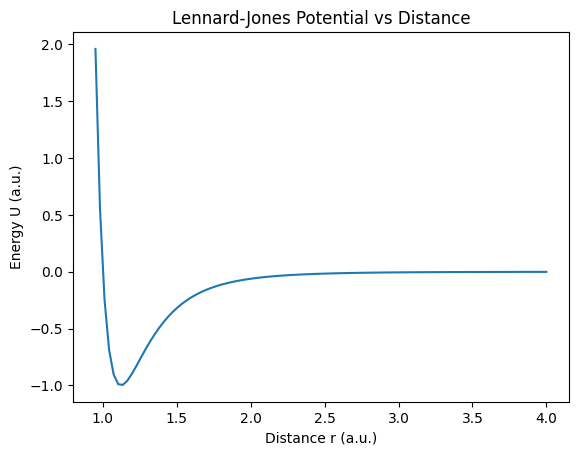

In [68]:
def magnitude2(x):
    return (x*x).sum(axis=0)

def pair_U_lj(x):
    return 4*(x**-6 - 1)*x**-6

# R_CUTOFF = L.min()/2
R_CUTOFF = 2.5
R_CUTOFF2 = R_CUTOFF**2
U_CUTOFF = pair_U_lj(R_CUTOFF)
print(f"R_CUTOFF: {R_CUTOFF}")
print(f"U_CUTOFF: {U_CUTOFF}")

def pair_U_lj_vec(r):
    r2 = magnitude2(r)
    return (r2<R_CUTOFF2) * (4*(r2**-3 - 1)*r2**-3 - U_CUTOFF)
    # return 4*(r2**-3 - 1)*r2**-3 - U_CUTOFF

def pair_F_lj_vec(r):
    r2 = magnitude2(r)
    return (r2<R_CUTOFF2) * (-48*(r2**-3 - 0.5)*r2**-4 * r)

print("testing with r as [xs, ys]")
rtest = np.array([[1,2,3],[2,3,4]], dtype=float)
print(rtest)
print(magnitude2(rtest))
print(pair_U_lj_vec(rtest))
print(pair_F_lj_vec(rtest))

print()
print("testing with r as [x matrix, y matrix]")
rmat = np.array([
    [[1,1,1],[2,2,2],[3,3,3]],
    [[2,3,4],[2,3,4],[2,3,4]],
], dtype=float)
print(magnitude2(rmat))
print(pair_U_lj_vec(rmat))
print(pair_F_lj_vec(rmat))

x = np.linspace(0.95,4,100)
plt.plot(x,pair_U_lj(x))

plt.title("Lennard-Jones Potential vs Distance")
plt.xlabel("Distance r (a.u.)")
plt.ylabel("Energy U (a.u.)")
plt.show()


-3.707118289474048
(2, 210, 210)
(2, 210)


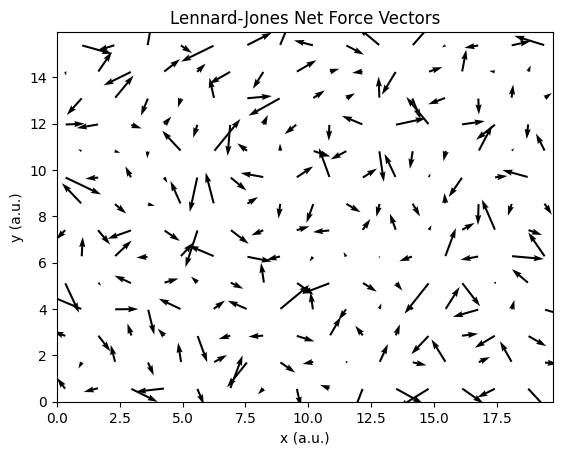

In [69]:
x = r[0]
def pair_displacements_1D(x):
    x = -np.diff(np.meshgrid(x,x),axis=0)[0]
    return x

def pair_displacements(r): # scuffed implmentation, will change later?
    D = []
    for i,x in enumerate(r):
        d = pair_displacements_1D(x)
        D.append( (L[i]/2+d)%L[i]-L[i]/2 )
    return np.array(D)

def magnitudes(v):
    return np.sqrt(np.sum(v**2,axis=0))

def pair_distances(r):
    return magnitudes(pair_displacements(r))

displacements = pair_displacements(r)

diag_mask = np.identity(N,dtype=int)==1

Us = pair_U_lj_vec(displacements)
Us[diag_mask] = 0
U = Us.sum()
U_av = U / N
print(U_av)

F_lj = pair_F_lj_vec(displacements)
F_lj[:,diag_mask] = 0
print(F_lj.shape)
F_net = F_lj.sum(axis=2)
print(F_net.shape)

# plt.quiver(np.repeat(r[0],N),np.repeat(r[1],N), displacements[0,:,:].ravel(),displacements[1,:,:].ravel(), angles="xy", scale=1, scale_units="xy")
def plot_each_arrow(r,A,color=None):
    if color is None: color=np.ones(len(A[0])**2)
    return plt.quiver(
        *[np.repeat(x,N)for x in r],
        *[A[i,:,:].ravel() for i in range(DIM)],
        color,
        angles="xy", scale=1, scale_units="xy")
# plot_each_arrow(r,lj_forces,magnitudes(lj_forces))
# plt.show()

# plt.title("Displacement Vectors")
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(r,displacements,magnitudes(displacements))
# plt.show()

# plt.title("Lennard-Jones Force Vectors")
# plt.xlim(0, L)
# plt.ylim(0, L)
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(
#     r,
#     lj_forces / magnitudes(lj_forces),
#     np.clip(magnitudes(lj_forces),0,1),
# )
# plt.colorbar()
# plt.text(L*0.1,L*0.1, "Forces are clipped with upper bound 1")
# plt.show()

plt.title("Lennard-Jones Net Force Vectors")
plt.xlim(0, L[0])
plt.ylim(0, L[1])
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.quiver(*r, *F_net, angles="xy", )
plt.show()

In [70]:
class Calculate():
    def U_av(r):
        global N
        displacements = pair_displacements(r)
        Us = pair_U_lj_vec(displacements)
        Us[diag_mask] = 0
        return Us.sum() / N

    def F_lj(r):
        global N
        displacements = pair_displacements(r)
        diag_mask = np.identity(N,dtype=int)==1

        lj_forces = pair_F_lj_vec(displacements)
        lj_forces[:,diag_mask] = 0
        net_lj_force = lj_forces.sum(axis=2)
        return net_lj_force

    def a(r):
        return Calculate.F_lj(r)

def velocity_verlet(r,v,dt):
    a1 = Calculate.a(r)
    r = r + v*dt + a1/2 * dt**2
    a2 = Calculate.a(r)
    v = v + (a1+a2)/2*dt
    return r,v

def wall_boundary_conds(r,v):
    v *= 1 - (np.heaviside(r-L,0) * np.heaviside(v,0))*2
    v *= 1 - (np.heaviside(-r,0) * np.heaviside(-v,0))*2
    return r,v

def periodic_boundary_wrap(r,v):
    r = (r.T % L.T).T
    # this is due to a weird issue with numpy broadcasting and shape
    # the scatter plots require a list of x values followed by a list of y values
    # but this requires the (x,y) dimension to be the last one, so the transpose is taken
    return r,v

def boundary_conds(r,v):
    return periodic_boundary_wrap(r,v)

def step_state(r,v,dt):
    r,v = velocity_verlet(r,v,dt)
    r,v = boundary_conds(r,v)
    return r,v

In [71]:
def time_evolution(r,v,steps,dt):
    rs = np.zeros((steps,r.shape[0], r.shape[1]))
    vs = np.zeros((steps,r.shape[0], r.shape[1]))
    rs[0],vs[0] = r,v
    for i in range(steps-1):
        rs[i+1], vs[i+1] = step_state(rs[i],vs[i],dt)
    return rs, vs

In [72]:
t_total,dt = 10,0.001
steps = int(t_total//dt)
rs, vs = time_evolution(r,v,steps,dt)

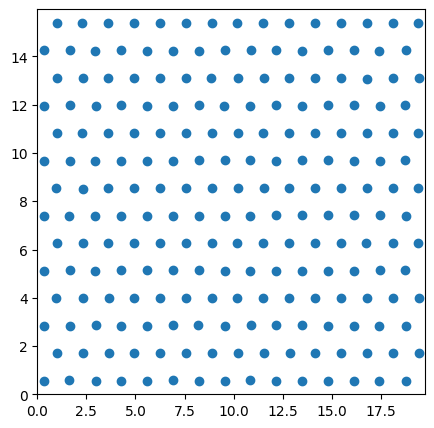

In [73]:
ANIMATE = True
if ANIMATE:
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    points = ax.scatter(*rs[0])

    fps = 30
    t_anim = 5
    k = steps//(fps*t_anim) # inverse frame density
    nframes = steps // k

    ax.set_xlim(0, L[0])
    ax.set_ylim(0, L[1])
    def animation_frame(i):
        points.set_offsets(rs[i*k].T)

    lj_anim = animation.FuncAnimation(fig, animation_frame, frames=nframes)
    lj_anim.save("test.gif", writer="pillow", fps=fps, dpi=100)

In [74]:
t = np.arange(steps)*dt
KE_t = (vs**2).sum(axis=(1,2))/N/2
U_t = np.array([Calculate.U_av(r) for r in rs])

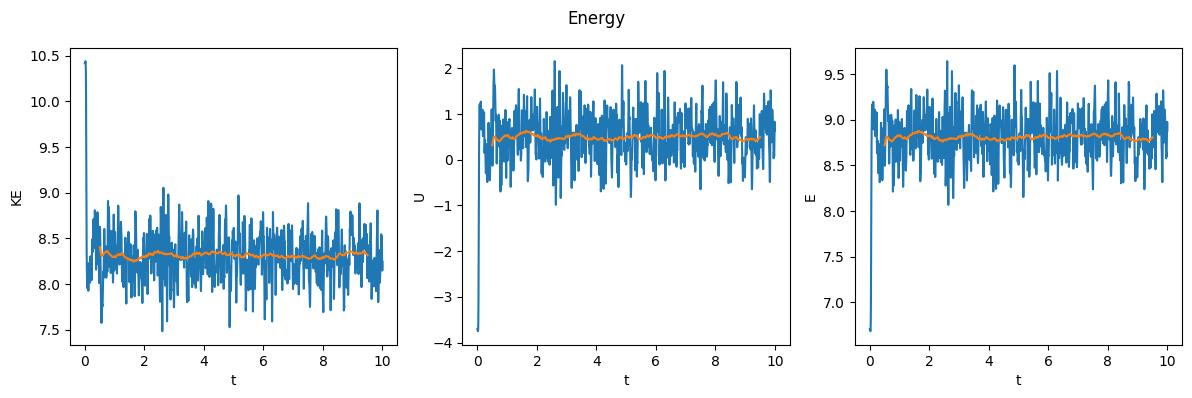

In [77]:
def window(size):
    return np.ones(size)/float(size)
WLEN = 1000

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

KE_t_win = np.convolve(KE_t, window(WLEN),'same')[WLEN//2:-WLEN//2]
ax1.plot(t,KE_t)
ax1.plot(t[WLEN//2:-WLEN//2], np.convolve(KE_t, window(WLEN),'same')[WLEN//2:-WLEN//2])
ax1.set_ylabel("KE")
ax1.set_xlabel("t")

U_t_win = np.convolve(U_t, window(WLEN),'same')[WLEN//2:-WLEN//2]
ax2.plot(t,U_t)
ax2.plot(t[WLEN//2:-WLEN//2], np.convolve(U_t, window(WLEN),'same')[WLEN//2:-WLEN//2])
ax2.set_ylabel("U")
ax2.set_xlabel("t")

E_t = KE_t + U_t
E_t_win = KE_t_win + U_t_win
ax3.plot(t,E_t)
ax3.plot(t[WLEN//2:-WLEN//2], E_t_win)
ax3.set_ylabel("E")
ax3.set_xlabel("t")

fig.suptitle("Energy")
fig.subplots_adjust(top=0.90)
fig.set_size_inches(12,4)
fig.tight_layout(pad=1)
fig.show()

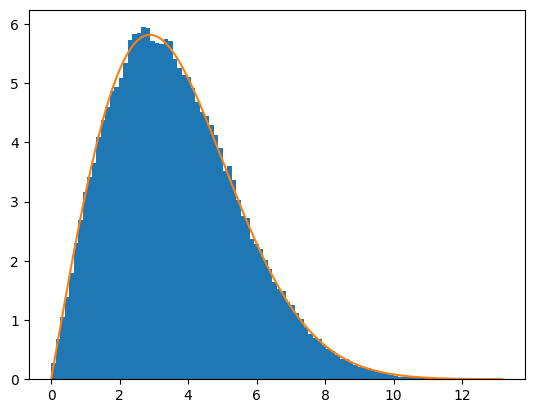

In [97]:
vs2 = vs**2
T_WIN = WLEN*9
vs2 = vs2[-T_WIN-1:-1]

T = KE_t_win[-1]
# D = lambda v: (2*np.pi*T)**(-3/2) * 4*np.pi*v**2 * np.exp(-v**2/(2*T))
D = lambda v: (1/T) * v * np.exp(-v**2/(2*T))

v_abs = np.sqrt((vs2).sum(axis=1))
v_abs = np.concatenate(v_abs)
v_range = np.linspace(0,v_abs.max(),1000)

fig, ax = plt.subplots()
# ax.hist(v_abs)
counts, bins = np.histogram(v_abs, bins=100)
ax.stairs(counts/T_WIN, bins, fill=True)
ax.plot(v_range, D(v_range)*N * (bins[1]-bins[0]))
fig.show()